In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import json
import os

sys.path.append(str(Path.cwd().parent))

from vae import generate, sample, dump
from src.load_model import load_model
import src.utils as utils

In [8]:
dataset = 'shapes'
# configure paths
models_path = f"../models/{dataset}"
dataset_path = f"../data/{dataset}"

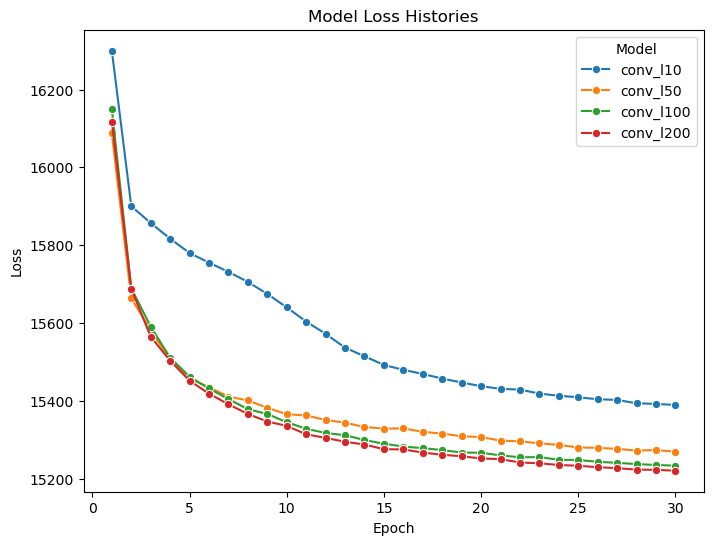

In [16]:
# Model comparison
loss_histories = []
# get dirs in models_path
models = os.listdir(models_path)
models = sorted(models, key=lambda x: int(x.replace('conv_l', '')))

# Load loss histories from each model
for model_name in models:
    config = utils.load_model_config(os.path.join(models_path, model_name))
    loss_histories.append((model_name, config["loss_history"]))

# Prepare data for plotting
data = []
for model_name, history in loss_histories:
    for epoch, loss in enumerate(history):
        data.append({"Model": model_name, "Epoch": epoch + 1, "Loss": loss})

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Model", marker="o")
plt.title('Model Loss Histories')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Model')
plt.show()

[14798 26247 27898]


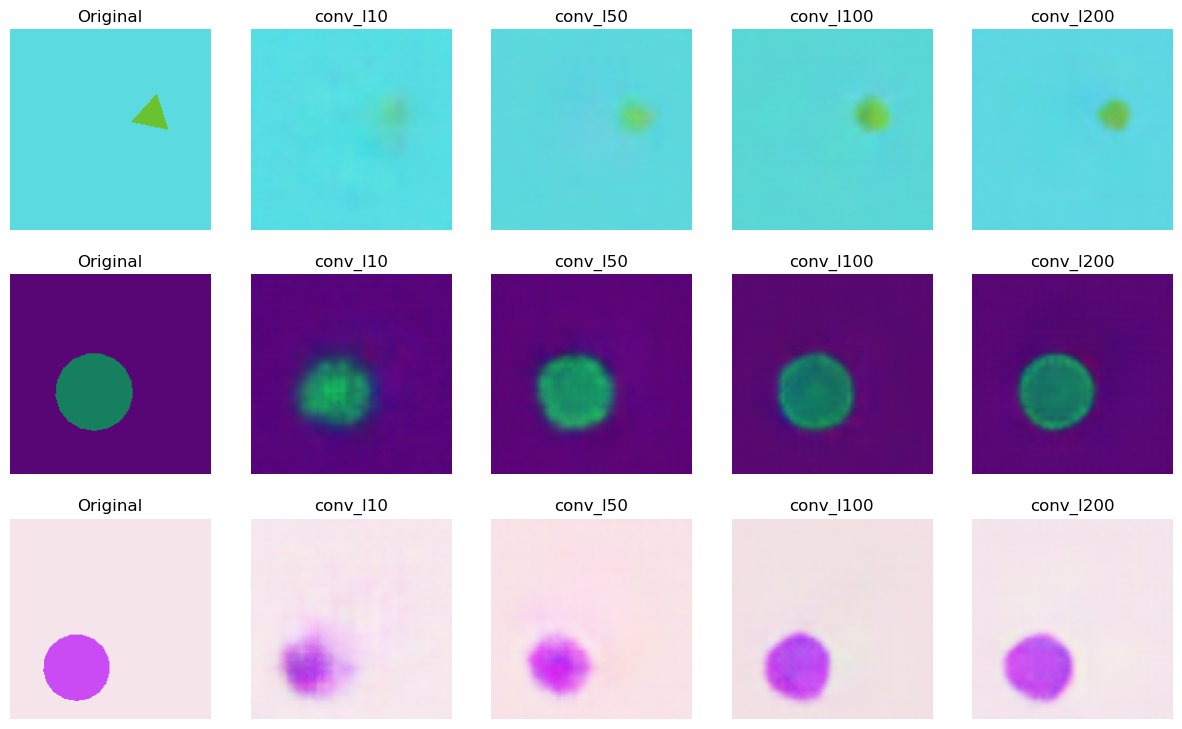

In [27]:
# load dump
dump_file_path = f"../dumps/{dataset}/conv_l100.csv"
df = pd.read_csv(dump_file_path)

n = len(models) + 1
amount = 3
plt.figure(figsize=(15, 3 * amount))

ids = np.random.choice(df.index, amount)
print(ids)

image_paths = []
for i, id in enumerate(ids):
    image_path = df.loc[id, "image"]
    image_paths.append(image_path)
    plt.subplot(amount, n, 1 + i * n)
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title("Original")

for i, model_name in enumerate(models):
    # Load model
    model_path = os.path.join(models_path, model_name)
    model, device = load_model(model_path)
    config = utils.load_model_config(model_path)
    
    for y, image_path in enumerate(image_paths):
        # encode and sample
        image = utils.image_to_tensor(image_path, resize=config["resize"], grayscale=config["grayscale"])
        mean, std = model.dump_latent(image, device)
        epsilon = np.random.normal(0, 1, mean.shape)
        latent_vector = mean + epsilon * std
        latent_vector = np.array(latent_vector, dtype=np.float32)
        # reconstruct
        output = model.generate(latent_vector, device)
        diff_image = utils.convert_tensor_to_image(output)
        # plot
        plt.subplot(amount, n, i + 2 + y * n)
        plt.imshow(diff_image)
        plt.axis("off")
        plt.title(model_name)

plt.show()